# Nightly Price Prediction (MXN)

**Project:** Exploratory analysis and a regression model to estimate nightly lodging prices.

**Dataset:** `database.csv`

**Goals:**
- Explore variable distributions and their relationship with price.
- Visualize patterns (trends and correlations).
- Train a regression model and evaluate performance.


In [1]:
# Librerías principales
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge

# Configuración de estilo
sns.set_theme(style="whitegrid", palette="deep")
plt.rcParams["figure.figsize"] = (10, 6)

In [2]:
# Load data
file_path = "../database.csv"
df = pd.read_csv(file_path)

df.head()

,Estado,Ciudad,Colonia/Municipio,Tipo de alojamiento,Numero de cuartos,Numero de baños,Numero de huéspedes,Precio por noche estimado (MXN),Ocupación promedio (%)
0,Ciudad de México,Mexico City,Roma Norte,Departamento,1,1.0,2,2000,70
1,Ciudad de México,Mexico City,Roma Norte,Departamento,2,1.5,4,2500,70
2,Ciudad de México,Mexico City,Roma Norte,Casa,3,2.0,6,3000,70
3,Ciudad de México,Mexico City,Roma Norte,Casa,4,2.5,8,3600,70
4,Ciudad de México,Mexico City,Roma Sur,Departamento,1,1.0,2,1800,68


## Dataset structure
We review columns, data types, and missing values.


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540 entries, 0 to 539
Data columns (total 9 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Estado                           540 non-null    object 
 1   Ciudad                           540 non-null    object 
 2   Colonia/Municipio                540 non-null    object 
 3   Tipo de alojamiento              540 non-null    object 
 4   Numero de cuartos                540 non-null    int64  
 5   Numero de baños                  540 non-null    float64
 6   Numero de huéspedes              540 non-null    int64  
 7   Precio por noche estimado (MXN)  540 non-null    int64  
 8   Ocupación promedio (%)           540 non-null    int64  
dtypes: float64(1), int64(4), object(4)
memory usage: 38.1+ KB


In [4]:
# Resumen estadístico de variables numéricas
_df_num = df.select_dtypes(include=["number"])
_df_num.describe()

,Numero de cuartos,Numero de baños,Numero de huéspedes,Precio por noche estimado (MXN),Ocupación promedio (%)
count,540.000000,540.000000,540.000000,540.000000,540.000000
mean,2.500000,1.750000,5.000000,1843.205556,47.770370
std,1.119071,0.559535,2.238141,1684.148335,7.951561
min,1.000000,1.000000,2.000000,350.000000,23.000000
25%,1.750000,1.375000,3.500000,1038.750000,43.000000
50%,2.500000,1.750000,5.000000,1440.000000,48.000000
75%,3.250000,2.125000,6.500000,2000.000000,52.000000
max,4.000000,2.500000,8.000000,13500.000000,70.000000


In [5]:
# Valores faltantes
missing = df.isna().sum().sort_values(ascending=False)
missing[missing > 0]

Series([], dtype: int64)

## Light cleaning and adjustments
- Normalize column names for convenience.
- Fix basic inconsistencies if present.


In [6]:
# Normalize columns
rename_map = {
    "Numero de cuartos": "num_cuartos",
    "Numero de baños": "num_banos",
    "Numero de huéspedes": "num_huespedes",
    "Precio por noche estimado (MXN)": "precio_noche_mxn",
    "Ocupación promedio (%)": "ocupacion_promedio",
    "Tipo de alojamiento": "tipo_alojamiento",
    "Colonia/Municipio": "colonia_municipio",
}

df = df.rename(columns=rename_map)

df.head()

,Estado,Ciudad,colonia_municipio,tipo_alojamiento,num_cuartos,num_banos,num_huespedes,precio_noche_mxn,ocupacion_promedio
0,Ciudad de México,Mexico City,Roma Norte,Departamento,1,1.0,2,2000,70
1,Ciudad de México,Mexico City,Roma Norte,Departamento,2,1.5,4,2500,70
2,Ciudad de México,Mexico City,Roma Norte,Casa,3,2.0,6,3000,70
3,Ciudad de México,Mexico City,Roma Norte,Casa,4,2.5,8,3600,70
4,Ciudad de México,Mexico City,Roma Sur,Departamento,1,1.0,2,1800,68


## Exploratory data analysis (EDA)


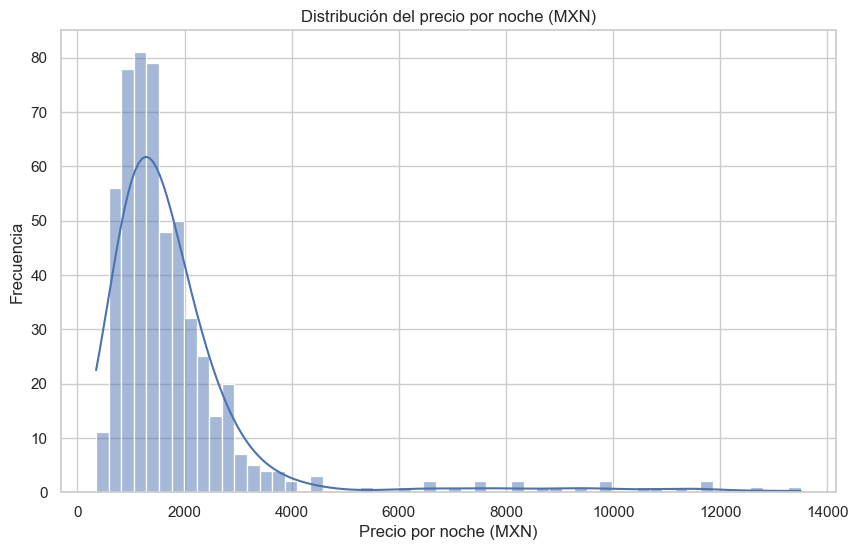

In [7]:
# Distribución del precio
sns.histplot(df["precio_noche_mxn"], kde=True)
plt.title("Distribución del precio por noche (MXN)")
plt.xlabel("Precio por noche (MXN)")
plt.ylabel("Frecuencia")
plt.show()

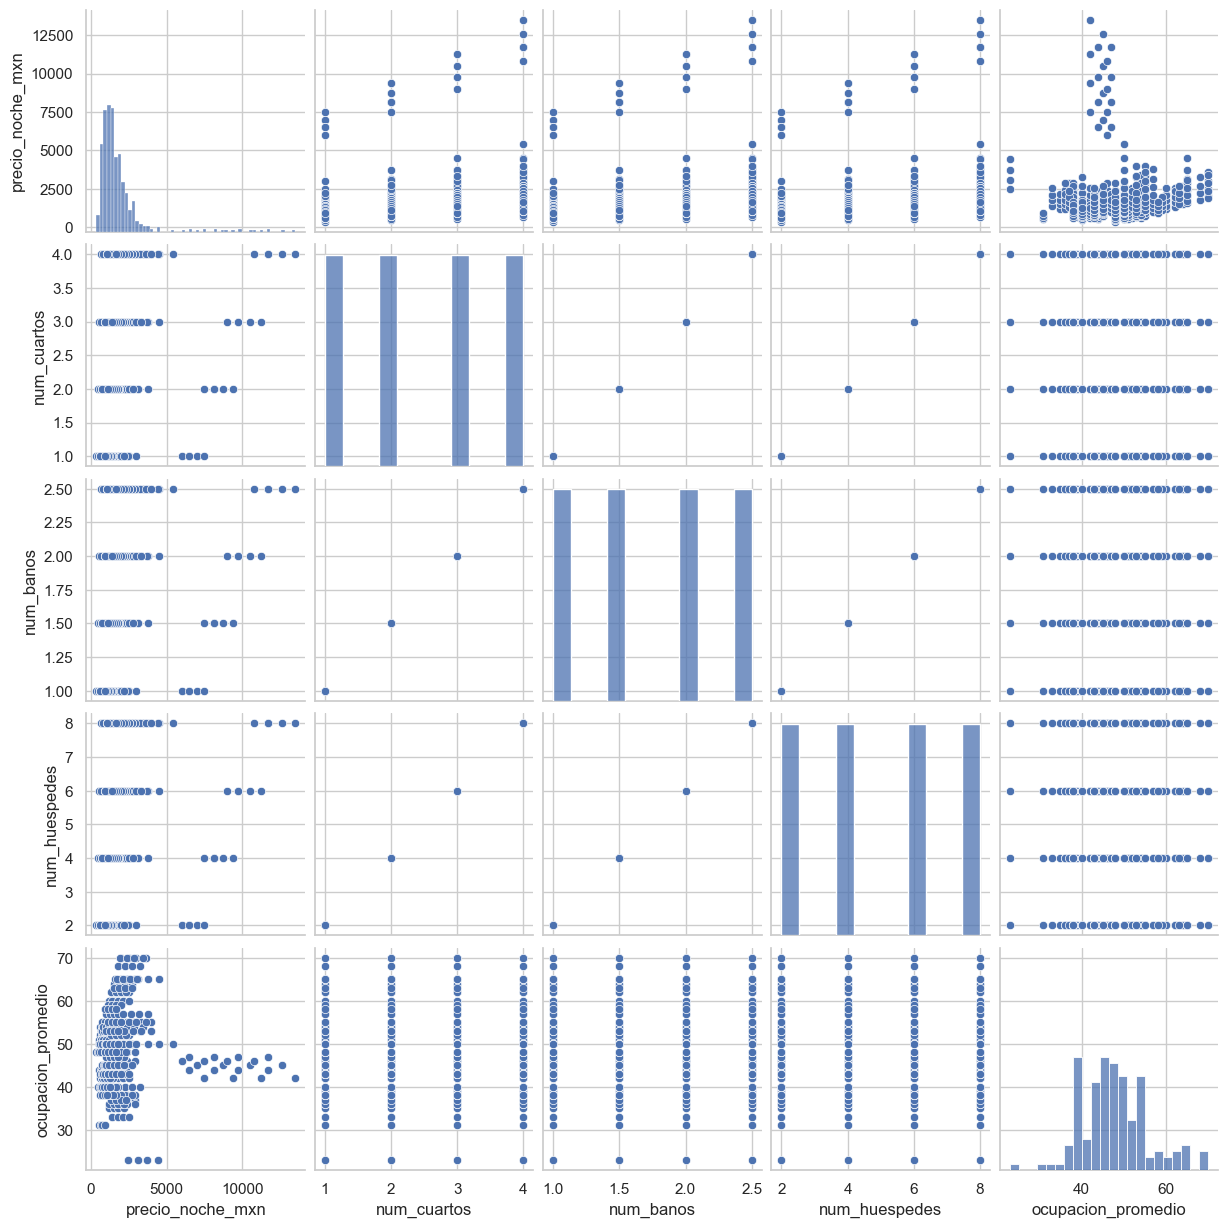

In [8]:
sns.pairplot(df[["precio_noche_mxn", "num_cuartos", "num_banos", "num_huespedes", "ocupacion_promedio"]])

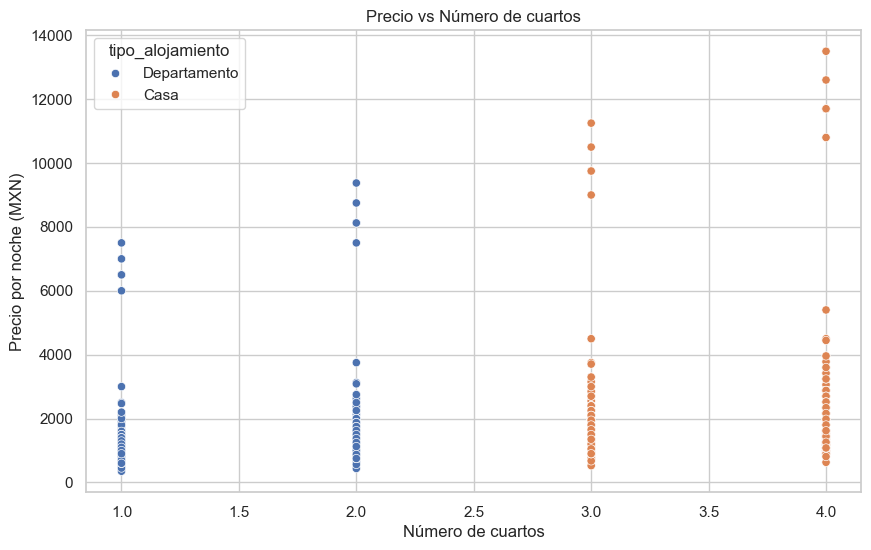

In [9]:
# Precio vs número de cuartos
sns.scatterplot(data=df, x="num_cuartos", y="precio_noche_mxn", hue="tipo_alojamiento")
plt.title("Precio vs Número de cuartos")
plt.xlabel("Número de cuartos")
plt.ylabel("Precio por noche (MXN)")
plt.show()

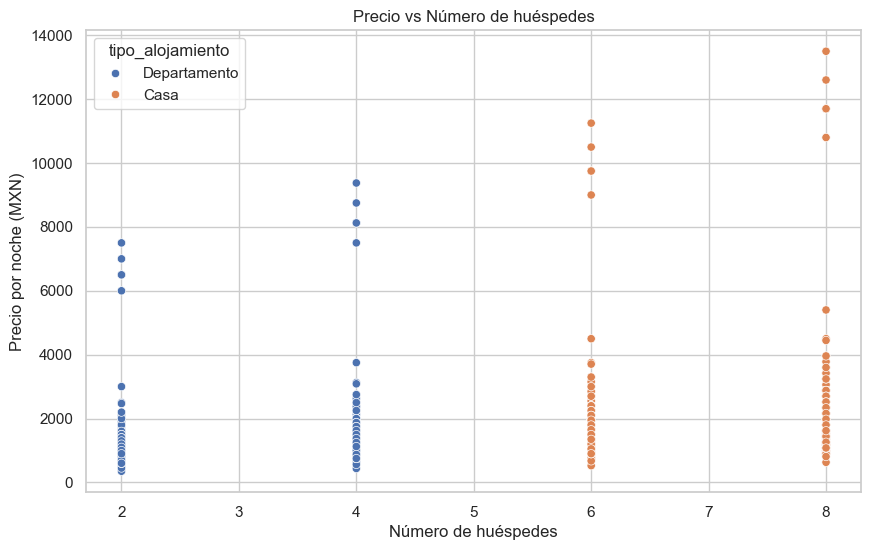

In [10]:
# Precio vs número de huéspedes
sns.scatterplot(data=df, x="num_huespedes", y="precio_noche_mxn", hue="tipo_alojamiento")
plt.title("Precio vs Número de huéspedes")
plt.xlabel("Número de huéspedes")
plt.ylabel("Precio por noche (MXN)")
plt.show()

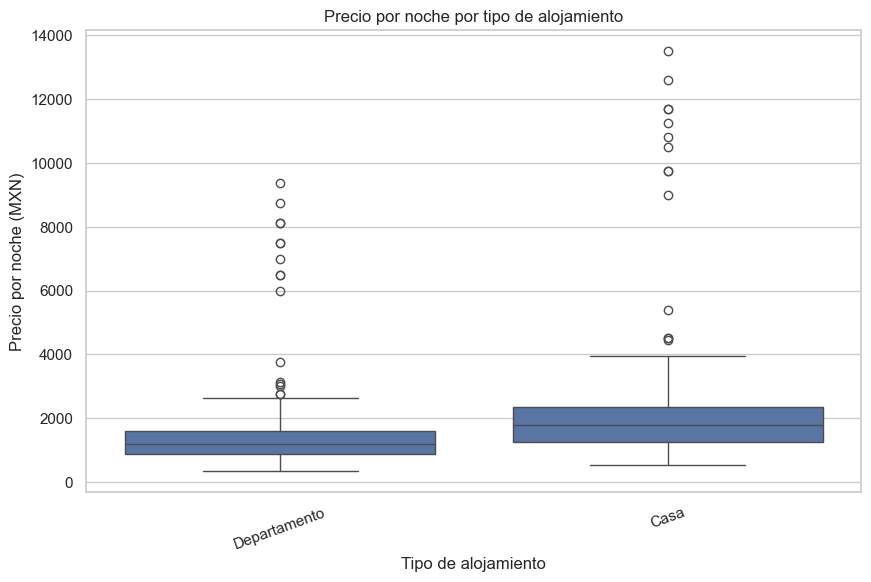

In [11]:
# Boxplot por tipo de alojamiento
sns.boxplot(data=df, x="tipo_alojamiento", y="precio_noche_mxn")
plt.title("Precio por noche por tipo de alojamiento")
plt.xlabel("Tipo de alojamiento")
plt.ylabel("Precio por noche (MXN)")
plt.xticks(rotation=20)
plt.show()

## Correlations between numeric variables


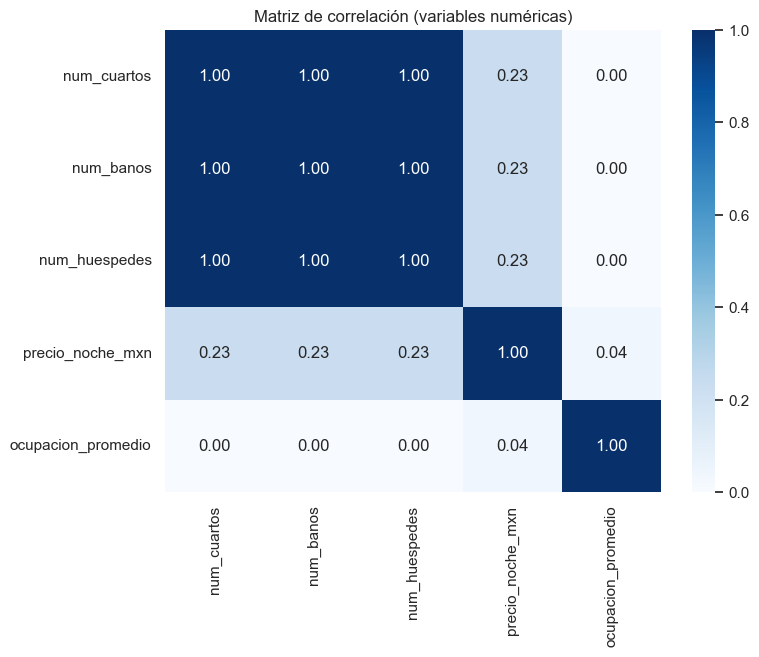

In [12]:
# Matriz de correlación
corr = df.select_dtypes(include=["number"]).corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap="Blues", fmt=".2f")
plt.title("Matriz de correlación (variables numéricas)")
plt.show()

## Model preparation
- Categorical variables: State, City, neighborhood/municipality, lodging type.
- Numeric variables: rooms, bathrooms, guests, occupancy.
- Model: Linear regression (with Ridge option for regularization).


In [13]:
# Selección de variables
features = [
    "Estado",
    "Ciudad",
    "colonia_municipio",
    "tipo_alojamiento",
    "num_cuartos",
    "num_banos",
    "num_huespedes",
    "ocupacion_promedio",
]

target = "precio_noche_mxn"

X = df[features]
y = df[target]

In [14]:
# Columnas categóricas y numéricas
categorical_features = ["Estado", "Ciudad", "colonia_municipio", "tipo_alojamiento"]
numeric_features = ["num_cuartos", "num_banos", "num_huespedes", "ocupacion_promedio"]

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("num", "passthrough", numeric_features),
    ]
)

# Pipeline con modelo
model = Ridge(alpha=1.0)

pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", model),
    ]
)

In [15]:
# División train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Entrenamiento
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Estado', 'Ciudad',
                                                   'colonia_municipio',
                                                   'tipo_alojamiento']),
                                                 ('num', 'passthrough',
                                                  ['num_cuartos', 'num_banos',
                                                   'num_huespedes',
                                                   'ocupacion_promedio'])])),
                ('model', Ridge())])

In [16]:
# Evaluación
preds = pipeline.predict(X_test)

mae = mean_absolute_error(y_test, preds)
rmse = root_mean_squared_error(y_test, preds)
r2 = r2_score(y_test, preds)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")

MAE: 218.65
RMSE: 481.96
R2: 0.91


## Comparison: actual vs prediction


In [17]:
# Comparación visual
comparison = pd.DataFrame({
    "Real": y_test.values,
    "Predicción": preds
})

comparison.head()

,Real,Predicción
0,1250,1288.369459
1,1500,1582.720040
2,750,703.697849
3,1350,1488.065196
4,2500,2700.955688


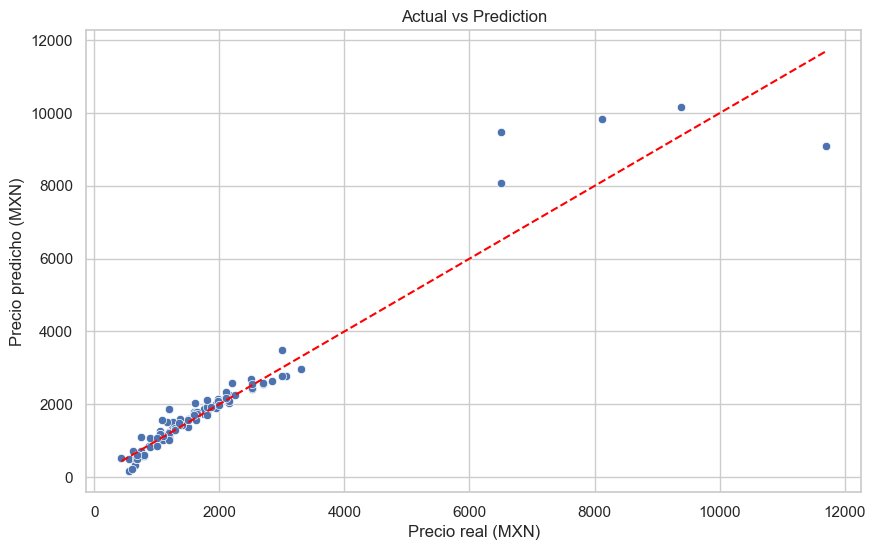

In [18]:
sns.scatterplot(data=comparison, x="Real", y="Predicción")
plt.plot([comparison["Real"].min(), comparison["Real"].max()],
         [comparison["Real"].min(), comparison["Real"].max()],
         color="red", linestyle="--")
plt.title("Actual vs Prediction")
plt.xlabel("Precio real (MXN)")
plt.ylabel("Precio predicho (MXN)")
plt.show()

## Conclusions
- Relationships appear between price and variables like rooms and guests.
- The regression model provides a first approximation for price estimation.
- More data can improve accuracy and enable more complex models.
